In [47]:
import os
path='/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'
files=[os.path.join(path,i) for i in os.listdir(path)]
len(files)

202599

(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)


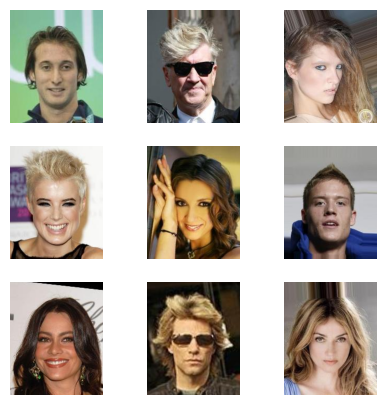

In [48]:
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(5,5))
for i in range(9):
    rand_int=random.randint(0,len(files))
    plt.subplot(3,3,i+1)
    img=plt.imread(files[rand_int])
    print(img.shape)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [49]:
import tensorflow as tf

def preprocessing(file):
    img=tf.io.read_file(file)
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.resize(img,[224,224])
    img=tf.cast(img,tf.float32)/255
    gray_img=tf.image.rgb_to_grayscale(img)
    return gray_img,img

AUTOTUNE=tf.data.AUTOTUNE
dataset=tf.data.Dataset.from_tensor_slices(files[:150000])
dataset=dataset.map(preprocessing,num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

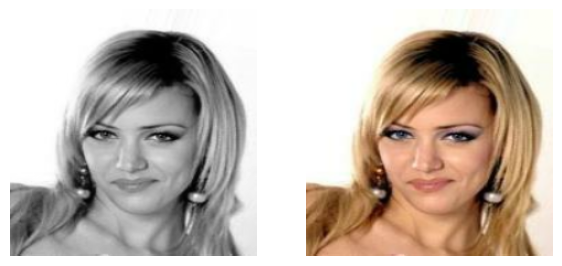

In [50]:
plt.figure(figsize=(7,7))
for (i,j) in dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow(i[1],cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(j[1])
    plt.axis('off')

In [51]:
from tensorflow.keras.layers import Conv2D,Input,Conv2DTranspose,MaxPooling2D,Dropout,Concatenate
from tensorflow.keras.models import Model,Sequential

In [52]:
def conv_down(inputs,n_filters,pool=True,dropout=0):
    x=Conv2D(n_filters,kernel_size=3,padding='same',activation='relu')(inputs)
    x=Conv2D(n_filters,kernel_size=3,padding='same',activation='relu')(x)
    if dropout !=0:
        x=Dropout(dropout)(x)
    x_pool=x
    if pool:
        x_pool=MaxPooling2D(2)(x)
    return x_pool,x

In [53]:
def conv_up(n_filters,concat_input,inputs):
    x=Conv2DTranspose(n_filters,3,strides=2,padding='same',activation='relu')(inputs)
    x=Concatenate()([x,concat_input])
    x=Conv2D(n_filters,kernel_size=3,padding='same',activation='relu')(x)
    x=Conv2D(n_filters,kernel_size=3,padding='same',activation='relu')(x)
    return x

In [54]:
def U_NET(inputs=(224,224,1),n_filters=32):
    inputs=Input(inputs)
    block_1=conv_down(inputs,n_filters)
    block_2=conv_down(block_1[0],n_filters*2)
    block_3=conv_down(block_2[0],n_filters*4)
    block_4=conv_down(block_3[0],n_filters*8)
    block_5=conv_down(block_4[0],n_filters*16,pool=False)

    block_6=conv_up(n_filters*8,block_4[1],block_5[0])
    block_7=conv_up(n_filters*4,block_3[1],block_6)
    block_8=conv_up(n_filters*2,block_2[1],block_7)
    block_9=conv_up(n_filters,block_1[1],block_8)


    block_10=Conv2D(n_filters,kernel_size=3,padding='same',activation='relu')(block_9)
    block_11=Conv2D(3,kernel_size=1,padding='same',activation='sigmoid')(block_10)
    model=Model(inputs,block_11)
    return model

In [55]:
U_NET().summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 224, 224,  │        320 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 224, 224,  │      9,248 │ conv2d_114[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 112, 112,  │          0 │ conv2d_115[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 112, 112,  │     18,496 │ max_pooling2d_32… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 112, 112,  │     36,928 │ conv2d_116[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 56, 56,    │          0 │ conv2d_117[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 56, 56,    │     73,856 │ max_pooling2d_33… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 56, 56,    │    147,584 │ conv2d_118[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_34    │ (None, 28, 28,    │          0 │ conv2d_119[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 28, 28,    │    295,168 │ max_pooling2d_34… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 28, 28,    │    590,080 │ conv2d_120[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_35    │ (None, 14, 14,    │          0 │ conv2d_121[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 14, 14,    │  1,180,160 │ max_pooling2d_35… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 14, 14,    │  2,359,808 │ conv2d_122[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_19 │ (None, 28, 28,    │  1,179,904 │ conv2d_123[0][0]  │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 28, 28,    │          0 │ conv2d_transpose

 Total params: 8,639,235 (32.96 MB)

 Trainable params: 8,639,235 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model=U_NET()
model.compile(optimizer='adam',loss='mse',metrics=['mae'])

In [57]:
history=model.fit(dataset,epochs=6)

Epoch 1/6
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1081s 229ms/step - loss: 0.0070 - mae: 0.0491
Epoch 2/6
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1067s 228ms/step - loss: 0.0042 - mae: 0.0378
Epoch 3/6
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1067s 228ms/step - loss: 0.0041 - mae: 0.0368
Epoch 4/6
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1067s 228ms/step - loss: 0.0040 - mae: 0.0363
Epoch 5/6
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1067s 227ms/step - loss: 0.0039 - mae: 0.0359
Epoch 6/6
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 1068s 228ms/step - loss: 0.0039 - mae: 0.0356


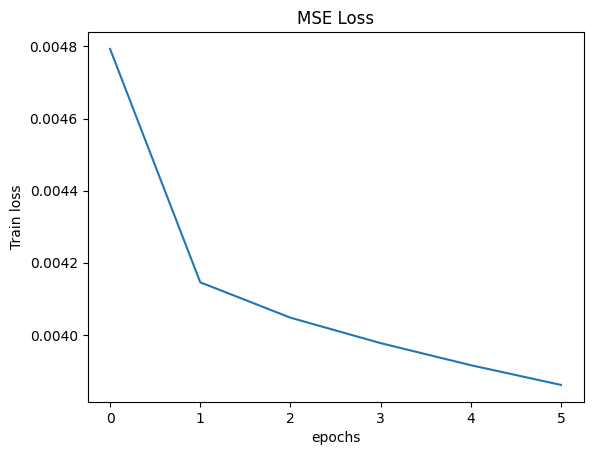

In [71]:
history.history.keys()
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Train loss')
plt.title('MSE Loss')
plt.show()

In [95]:
rand_int=random.randint(150000,200000)
image=tf.io.read_file('/kaggle/input/test-data/WhatsApp Image 2025-11-30 at 01.16.59_5b38360f.jpg')
image=tf.image.decode_jpeg(image,channels=3)
image=tf.image.resize(image,[224,224])
image=tf.cast(image,tf.float32)/255.0
gray=tf.image.rgb_to_grayscale(image)
gray_input = tf.expand_dims(gray, axis=0)
prediction=model.predict(gray_input)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


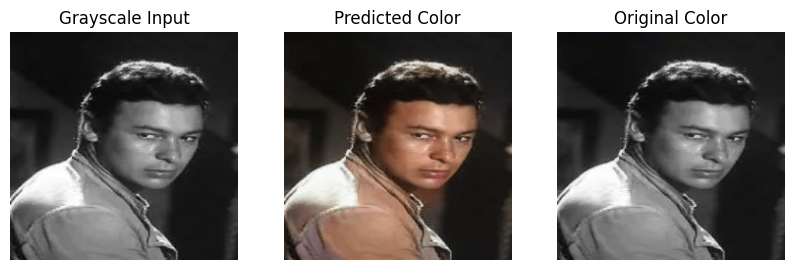

In [96]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Grayscale Input")
plt.imshow(tf.squeeze(gray), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Color")
plt.imshow(tf.clip_by_value(prediction, 0.0, 1.0))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Original Color")
plt.imshow(image)
plt.axis('off')

plt.show()

In [73]:
model.save('image_colorization_model.keras')